# Part 2: Building a simple chess playing model

To build an AI that plays chess we need to write a function that accepts a board state (specified in FEN) and returns a move (specified in SAN).

We can use python-chess to list all the legal moves, so a very dumb way to play chess would be to randomly pick a legal move. Let's code that up first!

In [48]:
!pip install python-chess
import random
import chess

def play_random(fen):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then randomly pick a legal move:
    move = random.choice(list(board.legal_moves))

    # Now we turn our move into a string, return it and call it a day!
    return str(move)

In [ ]:
# Let's play against it!
# To make it easy to code up we'll always play as white.
from IPython.display import SVG, display

# Our play function accepts whatever strategy our AI is using, like play_random from above
def play_game(ai_function):
    board = chess.Board()

    while board.outcome() is None:
        # We print out the board as an SVG
        display(SVG(board._repr_svg_()))

        # If it's white's turn, we have the user play
        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            # The move a user puts in isn't a valid move, we keep prompting them for a valid move
            while user_move not in [str(move) for move in board.legal_moves]:
                print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
                user_move = input('Your move: ')
            board.push_san(user_move)

        # If it's black's turn, we have the AI play
        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            print(f'AI move: {ai_move}')
            board.push_san(ai_move)
    print(board.outcome())
        
play_game(play_random)

That's fun, but we should level up our game!
There are two ways we can think about building our model that come from Reinforcement Learning:

1. A Policy
2. A Value Function

In RL a policy is a function that goes from "world states" (everything our AI knows about the world) to actions. It's a pretty natural fit for chess, where our "world state" is our FEN string (the board) and actions are the legal chess moves our AI could make.

There's one catch: while our world state is relatively simple, there are a lot of potential moves our model needs to be able to put out. There are 64 possible starting square and 64 possible ending squares--so that's technically 64^2 = 4096 possible moves.

Whats more, on any given turn, most of those 4096 possible turns won't even be legal moves, so our model will have to try real hard just to output a move it's allowed to make. But we already know what moves are legal, python-chess gives that to us for free!

So another way we can think about this is to implement a `value function`. A value function basically just tells our AI how good a certain state of the world is.

For example, a board where we have all our pieces, and our opponent only has a king and 1 pawn is great for us, and our value function would put out a really high number. If this was reversed, we'd be doing terribly, and our value function would put out a really low number.

So instead of training our model to take in the board state and output a move (this would be treating our model as a policy) we could train our model to take in the board state and output a value (treating our model as a value function). Then we can just loop through all possible moves, rate all the possible board states after making those moves, and then pick the move with the highest board state.

# Preparing our Data
Before we feed our input into a neural network for training, we need to turn it all into numbers.

Once we replace the numbers with periods, our FEN notation is pretty close--it's an 8x8 grid of characters.

```
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
```

One commone strategy in machine learning is to _one hot encode_ our input. There are 13 different characters on our board right now: 6 upper case (white) pieces, 6 lower case (black) pieces, and . for empty spaces. So we could one-hot encode our input with a list of 13 elements, one for each piece type:

This could be the one hot encoding for a white Bishop:

```
 r n b q k p R N B Q K P .
[0 0 0 0 0 0 0 0 1 0 0 0 0]
```

And this could be the one hot encoding for an empty space:
```
 r n b q k p R N B Q K P .
[0 0 0 0 0 0 0 0 0 0 0 0 1]
```

Notice in both examples we only have 1 1, and all the rest are zeros.

In [51]:
# Lets code up a simple function to turn our chess pieces into one-hot encodings:

import numpy as np

def one_hot_encode_peice(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

# Let's test on a black bishop
one_hot_encode_peice('b')

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [52]:
# Now lets use that function to encode our entire board

def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_peice(piece))
        board_list.append(row_list)
    return np.array(board_list)

# Let's test on the starting board
encode_board(chess.Board())

array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

    

In [88]:
# Great! We can now use this function to get any board state ready for our model!
# We'll use pandas to pull in all our training data
import pandas as pd

train_df = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/train.csv', index_col='id')

# We'll only use the first 10000 examples so things run fast,
# but you'll get better performance if you remove this line
train_df = train_df[:10000]

# We'll also grab the last 1000 examples as a validation set
val_df = train_df[-1000:]
train_df.head()

,board,black_score,best_move
id,,,
80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [89]:
import numpy as np
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

# We'll stack all our encoded boards into a single numpy array
X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']


X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

# Building Our Model

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# With the Keras Sequential model we can stack neural network layers together
model = Sequential([
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1),
])

model.compile(
    optimizer='rmsprop',
    loss='mean_squared_error')

In [92]:
# To test things out, let's train for 20 epochs and see how our model is doing
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val))

Epoch 1/20
313/313 [==============================] - 2s 4ms/step - loss: 154100.3906 - val_loss: 140516.8438
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 150773.5625 - val_loss: 136599.1562
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 145985.4531 - val_loss: 132122.0312
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 141229.7188 - val_loss: 127980.5625
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 137281.1094 - val_loss: 124720.1172
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 134046.3906 - val_loss: 122247.8281
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 131216.7500 - val_loss: 120143.9766
Epoch 8/20
313/313 [==============================] - 1s 4ms/step - loss: 128608.2266 - val_loss: 118561.5781
Epoch 9/20
313/313 [==============================] - 1s 4ms/step - loss: 126414.6719 - val_loss: 116544.8984
Epoch 10/2

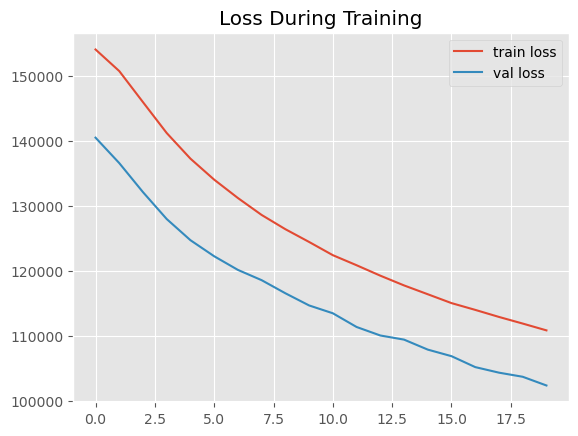

In [93]:
import matplotlib.pyplot as plt

# Lets plot the history of our training session to see how things progressed over time
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

Our training progress looks really good!

We see our training and validation loss both going down, and it looks like training more would get us even better results.

Play around with the size and shape of the neural network, and the number of epochs we train for to see if you can get better performance!

# Using our Value Function to create a Policy

So we have a decent value function now! We show it a board state, and it tells us how good that board is for black.

But if our AI is going to play chess, we need a way to turn that board state into a decision, or in other words, we need to use our value function to create a policy.

One simple way we can do this is to look at all the legal moves we can make, test our making each of them, and pick whatever move gives us the highest value to the resultant board state. Let's code that up!

In [94]:
def play_nn(fen, show_move_evaluations=False, player='b'):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then evaluate all legal moves
    moves = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        input_vector = encode_board(str(candidate_board)).astype(np.int32).flatten()
        
        # This is where our model gets to shine! It tells us how good the resultant score board is for black:
        score = model.predict(np.expand_dims(input_vector, axis=0), verbose=0)[0][0]
        moves.append((score, move))
        if show_move_evaluations:
            print(f'{move}: {score}')
    
    # By default sorting our moves will put the lowest scores at the top.
    # This would give us the right answer if we were playing as white,
    # but if we're playing as black we want to reverse things (then grab the first move):
    best_move = sorted(moves, reverse=player=='b')[0][1]

    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [ ]:
# Now that we have a policy, we can play against it!

play_game(play_nn)

So our model isn't perfect, but it's much smarter than playing randomly!

In our final notebook we'll see how to use our model to submit to our competition.